## **ISA 630 Final Project**

In [ ]:
##  Stock Price
## Ticker: TSLA
import yfinance as yf

df = yf.download('INTC', start = '2015-01-01', end = '2024-05-06')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,36.669998,37.160000,36.110001,36.360001,28.073423,23605600
2015-01-05,36.200001,36.450001,35.939999,35.950001,27.756859,32785000
2015-01-06,36.080002,36.230000,35.259998,35.279999,27.239555,30847600
2015-01-07,35.639999,36.070000,35.270000,36.020000,27.810907,27725200
2015-01-08,36.369999,37.000000,36.259998,36.689999,28.328213,31765400


<Axes: xlabel='Date'>

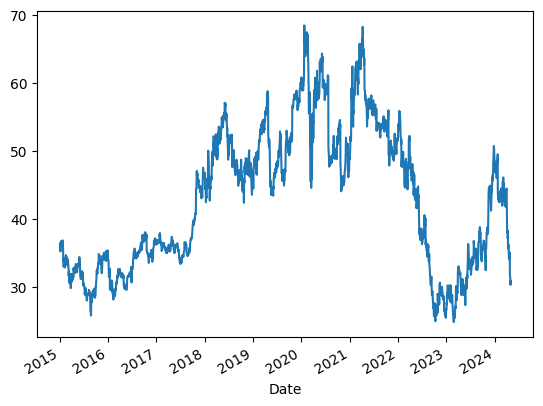

In [ ]:
## plot
df['Close'].plot()

## **Preprocessing**

We need to proccess the data so it can be fit to the model with the following steps.

- Train/test split; This is not a random split because this is a time series problem. Rather we need to use a historical section of data, say from the start until the end of 2024, to predict a later section of the data, say the stock price each day in 2024.
- Scaling; We need to scale the values. Since we are using a neural network, this prevents the vanishing gradient or exploding gradient effect from occuring.
- Feature Engineering; we need to establish our lagged variables to act as the features in the RNN.

In [ ]:
## train/test split
train = df['Close'][:'2023-12-31'] ## From Start of Data to 2024
test = df['Close']['2024-01-01':] ## 2024 Data

In [ ]:
## Scaling

## standardize the data
## to avoid the vanishing gradient or exploding gradient effect
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train.values.reshape(-1,1))

scaled_train = scaler.transform(train.values.reshape(-1,1))
scaled_test = scaler.transform(test.values.reshape(-1,1))

In [ ]:
## this creates our lags (X_train, y_train)

import numpy as np
def split_sequence(sequence, n_steps):
 X, y = list(), list()
 for i in range(len(sequence)):
 # find the end of this pattern
  end_ix = i + n_steps
 # check if we are beyond the sequence
  if end_ix > len(sequence)-1:
    break
 # gather input and output parts of the pattern
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [ ]:
## X_train and y_train
X_train, y_train = split_sequence(scaled_train, 3) ## 3 lags
X_test, y_test = split_sequence(scaled_test, 3) ## 3 lags

### **Recurrent Neural Network**

In [ ]:
## RNN Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense  ## For project we can also use the LSTM, or a GRU. Code is exactly the same, just use the corresponding layer

rnn = Sequential()
rnn.add(SimpleRNN(units = 60, input_shape = (3,1), activation = 'relu', return_sequences = True))  ## input shape is (lags, 1). In this example its (5,1)
rnn.add(SimpleRNN(units = 30, activation = 'relu', return_sequences = True))
rnn.add(SimpleRNN(units = 20, activation = 'relu', return_sequences = True))
rnn.add(SimpleRNN(units = 15, activation = 'relu')) ## we are not returning sequences (default is False), because it is the last RNN layer
rnn.add(Dense(60, activation ='relu'))
rnn.add(Dense(30, activation = 'relu'))
rnn.add(Dense(1)) ## default is linear, which is nessecary for this problem.

In [ ]:
## compile
rnn.compile(optimizer = 'adam', loss = 'mse')

## callback
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

## fit
rnn.fit(X_train, y_train, epochs = 100, batch_size = 100, validation_data = [X_test, y_test], callbacks = early_stop)

Epoch 1/100
23/23 [==============================] - 11s 34ms/step - loss: 0.3418 - val_loss: 0.0500
Epoch 2/100
23/23 [==============================] - 0s 16ms/step - loss: 0.0282 - val_loss: 0.0289
Epoch 3/100
23/23 [==============================] - 1s 32ms/step - loss: 0.0170 - val_loss: 0.0215
Epoch 4/100
23/23 [==============================] - 1s 42ms/step - loss: 0.0137 - val_loss: 0.0192
Epoch 5/100
23/23 [==============================] - 1s 33ms/step - loss: 0.0128 - val_loss: 0.0167
Epoch 6/100
23/23 [==============================] - 1s 35ms/step - loss: 0.0120 - val_loss: 0.0163
Epoch 7/100
23/23 [==============================] - 1s 34ms/step - loss: 0.0114 - val_loss: 0.0158
Epoch 8/100
23/23 [==============================] - 1s 34ms/step - loss: 0.0110 - val_loss: 0.0158
Epoch 9/100
23/23 [==============================] - 1s 42ms/step - loss: 0.0106 - val_loss: 0.0136
Epoch 10/100
23/23 [==============================] - 1s 31ms/step - loss: 0.0099 - val_loss: 0.014

In [ ]:
## predictions
predictions = scaler.inverse_transform(rnn.predict(X_test))

3/3 [==============================] - 0s 5ms/step


In [ ]:
true = scaler.inverse_transform(y_test)
y_previous = df['Close']['2024-01-01':].shift(-1).dropna()
y_test_trimmed = true[:len(y_previous)]

# Now calculate the MSE and R-squared
mse = mean_squared_error(y_test_trimmed, y_previous, squared=False)
r_squared = r2_score(y_test_trimmed, y_previous)

# Print the results
print(f'The MSE is: {mse}')
print(f'The R-squared is: {r_squared}')

The MSE is: 1.164062870146414
The R-squared is: 0.938664452945072


The MSE is: 1.1863041762706832
The R-squared is: 0.9390840768714258


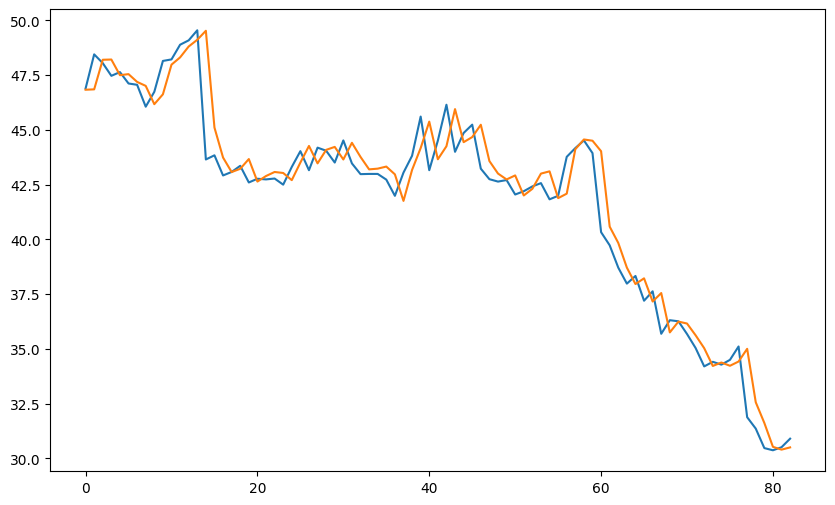

In [ ]:
 ## PERFORMANCE METRICS
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

print(f'The MSE is: {mean_squared_error(true, predictions, squared = False)}')
print(f'The R-squared is: {r2_score(true, predictions)}')

plt.figure(figsize = (10,6))
plt.plot(true)
plt.plot(pd.DataFrame(predictions))

## **RandomForest**

In [ ]:
## Lags for multiple predictors
## suppose you want to create lags for the variable close
import numpy as np
vars = ['Close']
l =5

for col in vars:
  lags = np.arange(1,l,1) ## middle value is number of lags
  for lag in lags:
    df["{}_Lag{}".format(col, lag)] = df[col].transform(lambda x: x.shift(lag))

In [ ]:
## drop all variables not lagged except for the y_variable (CLOSE)
rf_data = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1) ## inplace = True

In [ ]:
rf_data.dropna(inplace = True)

train = rf_data[:'2023-12-31']
test = rf_data['2024-01-01':]

X_train = train.drop(['Close'], axis = 1)
y_train = train.Close
X_test = test.drop(['Close'], axis =1)
y_test = test.Close

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
predictions = rf.predict(X_test)

In [ ]:
print(f'The MSE is: {mean_squared_error(y_test, predictions, squared = False)}')
print(f'The R-squared is: {r2_score(y_test, predictions)}')

The MSE is: 1.3616922870479322
The R-squared is: 0.9203826551504419


In [ ]:
## PREDICTION USING DAY BEFORE

y_test_trimmed = y_test[:len(y_previous)]

# Now calculate the MSE and R-squared
mse = mean_squared_error(y_test_trimmed, y_previous, squared=False)
r_squared = r2_score(y_test_trimmed, y_previous)

# Print the results
print(f'The MSE is: {mse}')
print(f'The R-squared is: {r_squared}')

The MSE is: 1.164062870146414
The R-squared is: 0.938664452945072
